In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
import numpy as np
import ydata_profiling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("Delinquency_prediction_dataset.csv")
df.head(10)

Customer_ID  Age    Income  Credit_Score  Credit_Utilization  \
0    CUST0001   56  165580.0         398.0            0.390502   
1    CUST0002   69  100999.0         493.0            0.312444   
2    CUST0003   46  188416.0         500.0            0.359930   
3    CUST0004   32  101672.0         413.0            0.371400   
4    CUST0005   60   38524.0         487.0            0.234716   
5    CUST0006   25   84042.0         700.0            0.650540   
6    CUST0007   38   35056.0         354.0            0.390581   
7    CUST0008   56  123215.0         415.0            0.532715   
8    CUST0009   36   66991.0         405.0            0.413035   
9    CUST0010   40   34870.0         679.0            0.361824   

   Missed_Payments  Delinquent_Account  Loan_Balance  Debt_to_Income_Ratio  \
0                3                   0       16310.0              0.317396   
1                6                   1       17401.0              0.196093   
2                0                   0       13761.0              0.301655   
3                3                   0       88778.0              0.264794   
4                2                   0       13316.0              0.510583   
5                6                   0       48361.0              0.260688   
6                3                   0        4638.0              0.484265   
7                5                   0       55776.0              0.358695   
8                5                   1           NaN              0.219854   
9                4                   0       93922.0              0.333081   

  Employment_Status  Account_Tenure Credit_Card_Type     Location  Month_1  \
0               EMP              18          Student  Los Angeles     Late   
1     Self-employed               0         Standard      Phoenix   Missed   
2     Self-employed               1         Platinum      Chicago   Missed   
3        Unemployed              15         Platinum      Phoenix     Late   
4     Self-employed              11         Standard      Phoenix   Missed   
5        Unemployed               7             Gold     New York  On-time   
6          employed              17         Platinum     New York  On-time   
7               EMP               1          Student     New York  On-time   
8          Employed              12          Student      Phoenix  On-time   
9               EMP               5         Business  Los Angeles  On-time   

   Month_2  Month_3  Month_4  Month_5  Month_6  
0     Late   Missed     Late   Missed     Late  
1   Missed     Late   Missed  On-time  On-time  
2     Late     Late  On-time   Missed     Late  
3   Missed     Late   Missed     Late     Late  
4  On-time   Missed     Late     Late     Late  
5     Late   Missed   Missed   Missed     Late  
6   Missed   Missed     Late   Missed     Late  
7  On-time  On-time     Late   Missed     Late  
8  On-time  On-time   Missed     Late  On-time  
9   Missed   Missed  On-time   Missed   Missed

In [3]:
from ydata_profiling import ProfileReport

# create the report
profile = ProfileReport(df, title="EDA Report")
profile.to_file("eda_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 68.94it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
profile.to_notebook_iframe()

Income has 39 (7.8%) missing values	Missing
Loan_Balance has 29 (5.8%) missing values	Missing
Customer_ID has unique values	Unique
Missed_Payments has 77 (15.4%) zeros	Zeros
Account_Tenure has 28 (5.6%) zeros	Zeros

In [5]:
#changing EMP, employed  labes to Employed

df['Employment_Status'].replace({
    'employed': 'Employed',
    'EMP': 'Employed'
},inplace=True)

In [6]:
df['Employment_Status'].value_counts()

Employment_Status
Employed         240
Unemployed        93
retired           87
Self-employed     80
Name: count, dtype: int64

In [7]:
# Number of records (rows, columns)
df.shape


(500, 19)

In [8]:
# Column names and data types
df.dtypes

Customer_ID              object
Age                       int64
Income                  float64
Credit_Score            float64
Credit_Utilization      float64
Missed_Payments           int64
Delinquent_Account        int64
Loan_Balance            float64
Debt_to_Income_Ratio    float64
Employment_Status        object
Account_Tenure            int64
Credit_Card_Type         object
Location                 object
Month_1                  object
Month_2                  object
Month_3                  object
Month_4                  object
Month_5                  object
Month_6                  object
dtype: object

In [9]:
# Check for missing values
df.isnull().sum()

Customer_ID              0
Age                      0
Income                  39
Credit_Score             2
Credit_Utilization       0
Missed_Payments          0
Delinquent_Account       0
Loan_Balance            29
Debt_to_Income_Ratio     0
Employment_Status        0
Account_Tenure           0
Credit_Card_Type         0
Location                 0
Month_1                  0
Month_2                  0
Month_3                  0
Month_4                  0
Month_5                  0
Month_6                  0
dtype: int64

In [10]:
# Percentage of missing values per column
df.isnull().mean() * 100

Customer_ID             0.0
Age                     0.0
Income                  7.8
Credit_Score            0.4
Credit_Utilization      0.0
Missed_Payments         0.0
Delinquent_Account      0.0
Loan_Balance            5.8
Debt_to_Income_Ratio    0.0
Employment_Status       0.0
Account_Tenure          0.0
Credit_Card_Type        0.0
Location                0.0
Month_1                 0.0
Month_2                 0.0
Month_3                 0.0
Month_4                 0.0
Month_5                 0.0
Month_6                 0.0
dtype: float64

In [11]:
# Check for duplicate rows
df.duplicated().sum()


0

Data imputation
income and loan balance  missing values replaced with median
credit score missing values replaced with mean


In [12]:


# Impute 'Income' and 'Loan_Balance' with median
median_imputer = SimpleImputer(strategy="median")
df[['Income', 'Loan_Balance']] = median_imputer.fit_transform(df[['Income', 'Loan_Balance']])

# Impute 'Credit_Score' with mean
mean_imputer = SimpleImputer(strategy="mean")
df[['Credit_Score']] = mean_imputer.fit_transform(df[['Credit_Score']])

# Confirm no missing values remain
print(df.isnull().sum())


Customer_ID             0
Age                     0
Income                  0
Credit_Score            0
Credit_Utilization      0
Missed_Payments         0
Delinquent_Account      0
Loan_Balance            0
Debt_to_Income_Ratio    0
Employment_Status       0
Account_Tenure          0
Credit_Card_Type        0
Location                0
Month_1                 0
Month_2                 0
Month_3                 0
Month_4                 0
Month_5                 0
Month_6                 0
dtype: int64


In [13]:
#  Keep only numeric columns 
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Correlation matrix
corr = numeric_df.corr()

In [14]:

%matplotlib inline


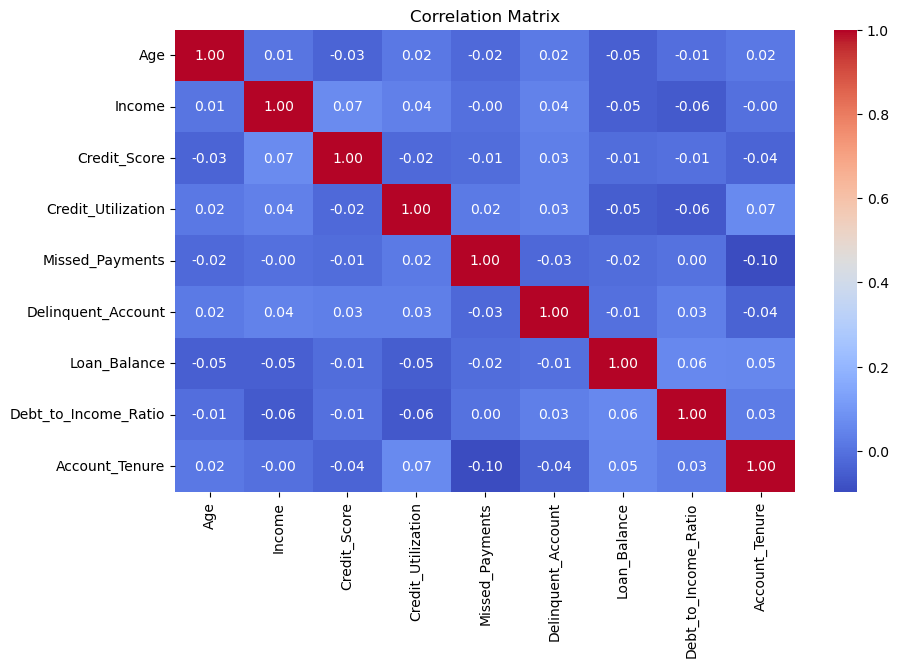

In [15]:
# Correlation matrix (numerical features only)
corr = numeric_df.corr()

# Heatmap of correlations
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()




In [16]:
 #correlation of each variable with delinquency
corr_with_target = corr['Delinquent_Account'].sort_values(ascending=False)
print(corr_with_target)



Delinquent_Account      1.000000
Income                  0.043991
Credit_Score            0.034820
Debt_to_Income_Ratio    0.034386
Credit_Utilization      0.034224
Age                     0.022508
Loan_Balance           -0.005438
Missed_Payments        -0.026478
Account_Tenure         -0.039829
Name: Delinquent_Account, dtype: float64


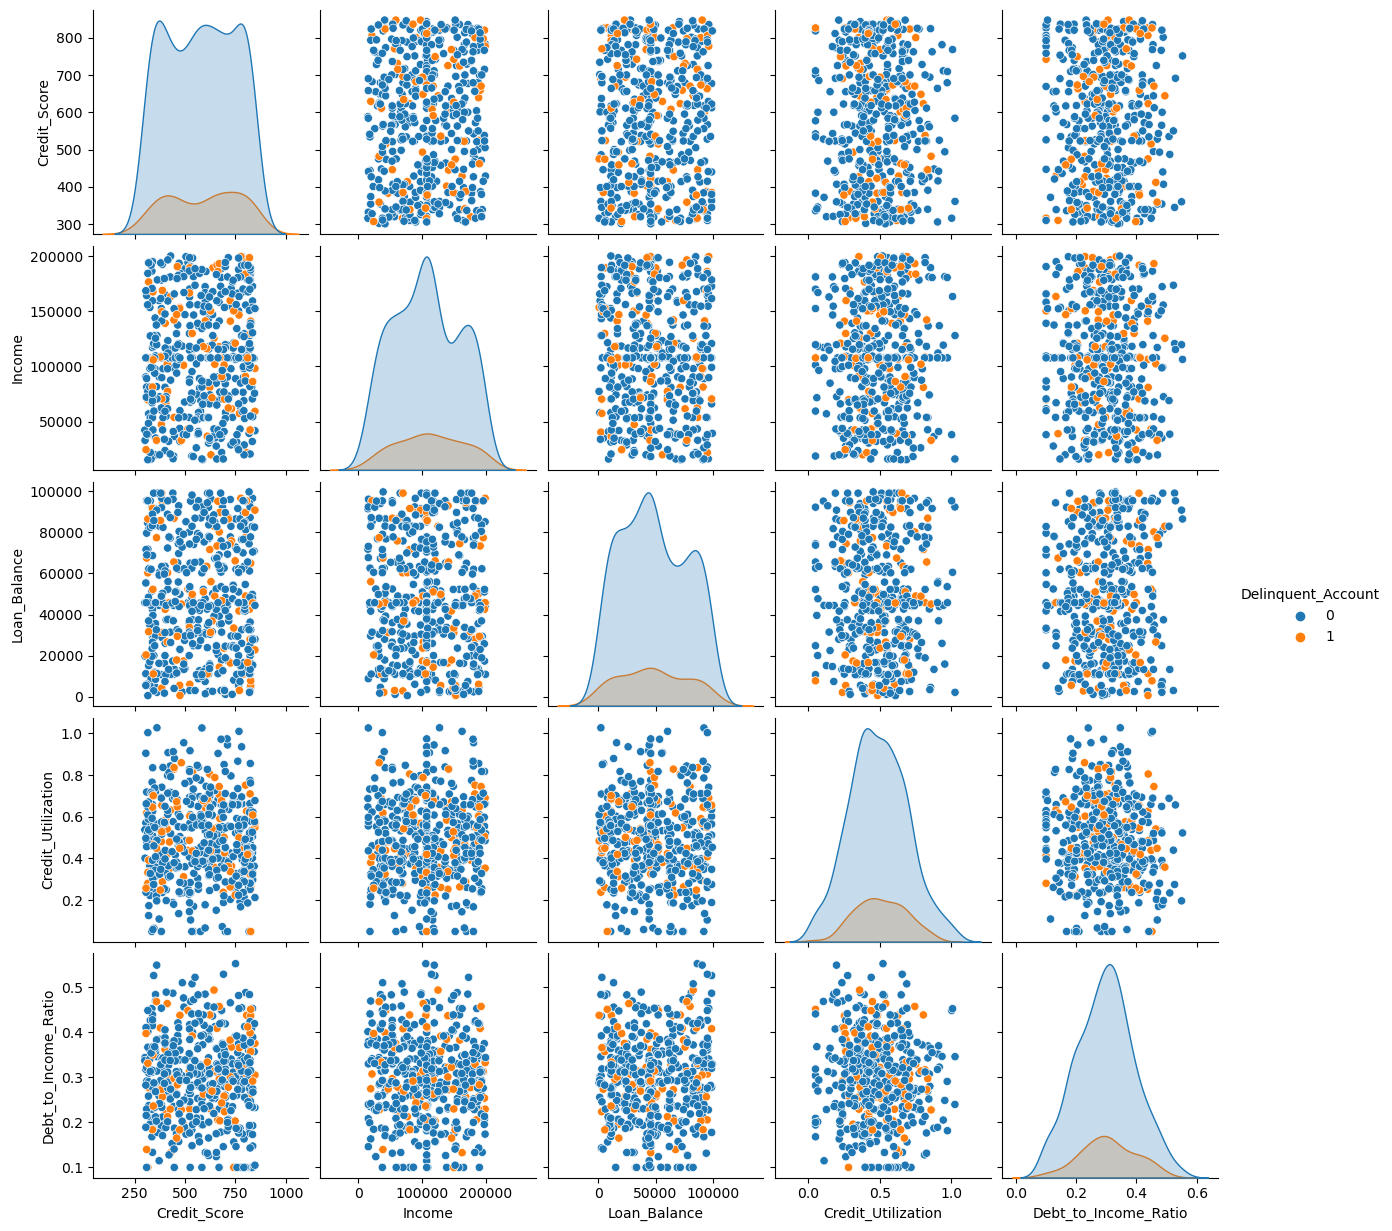

In [17]:
# Pairplot for key risk factors
sns.pairplot(df[['Credit_Score', 'Income', 'Loan_Balance', 
                       'Credit_Utilization', 'Debt_to_Income_Ratio', 
                       'Delinquent_Account']], hue="Delinquent_Account")
plt.show()

In [18]:
#calculate and display delinquency rates (%) across different categories

categorical_cols = ['Employment_Status', 'Debt_to_Income_Ratio', 'Credit_Score' , 'Credit_Utilization' ]

for col in categorical_cols:
    delinquency_rate = df.groupby(col)['Delinquent_Account'].mean().sort_values(ascending=False)*100
    print(f"\nDelinquency Rate by {col}:\n", delinquency_rate)

  


Delinquency Rate by Employment_Status:
 Employment_Status
Unemployed       19.354839
Employed         16.250000
Self-employed    16.250000
retired          11.494253
Name: Delinquent_Account, dtype: float64

Delinquency Rate by Debt_to_Income_Ratio:
 Debt_to_Income_Ratio
0.313142    100.0
0.438178    100.0
0.243359    100.0
0.367570    100.0
0.366179    100.0
            ...  
0.269624      0.0
0.269559      0.0
0.269109      0.0
0.268534      0.0
0.552956      0.0
Name: Delinquent_Account, Length: 487, dtype: float64

Delinquency Rate by Credit_Score:
 Credit_Score
378.0    100.0
412.0    100.0
445.0    100.0
805.0    100.0
731.0    100.0
         ...  
526.0      0.0
528.0      0.0
534.0      0.0
535.0      0.0
567.0      0.0
Name: Delinquent_Account, Length: 235, dtype: float64

Delinquency Rate by Credit_Utilization:
 Credit_Utilization
0.448492    100.0
0.257505    100.0
0.427107    100.0
0.337007    100.0
0.575592    100.0
            ...  
0.401246      0.0
0.400141      0.0
0.

In [19]:
# Employment Status
delinq_by_emp = df.groupby("Employment_Status")["Delinquent_Account"].mean() * 100

# Debt-to-Income Ratio (binning)
df["DTI_bin"] = pd.cut(df["Debt_to_Income_Ratio"], bins=[0,0.2,0.4,0.6,1.0])
delinq_by_dti = df.groupby("DTI_bin")["Delinquent_Account"].mean() * 100

# Credit Score (binning)
df["Credit_bin"] = pd.cut(df["Credit_Score"], bins=[300,500,600,700,850])
delinq_by_credit = df.groupby("Credit_bin")["Delinquent_Account"].mean() * 100

# Credit Utilization (binning)
df["Util_bin"] = pd.cut(df["Credit_Utilization"], bins=[0,0.3,0.5,0.7,1.0])
delinq_by_util = df.groupby("Util_bin")["Delinquent_Account"].mean() * 100

# Payment History (Missed Payments binning)
df["PayHist_bin"] = pd.cut(df["Missed_Payments"], bins=[0,2,5,10])
delinq_by_payhist = df.groupby("PayHist_bin")["Delinquent_Account"].mean() * 100


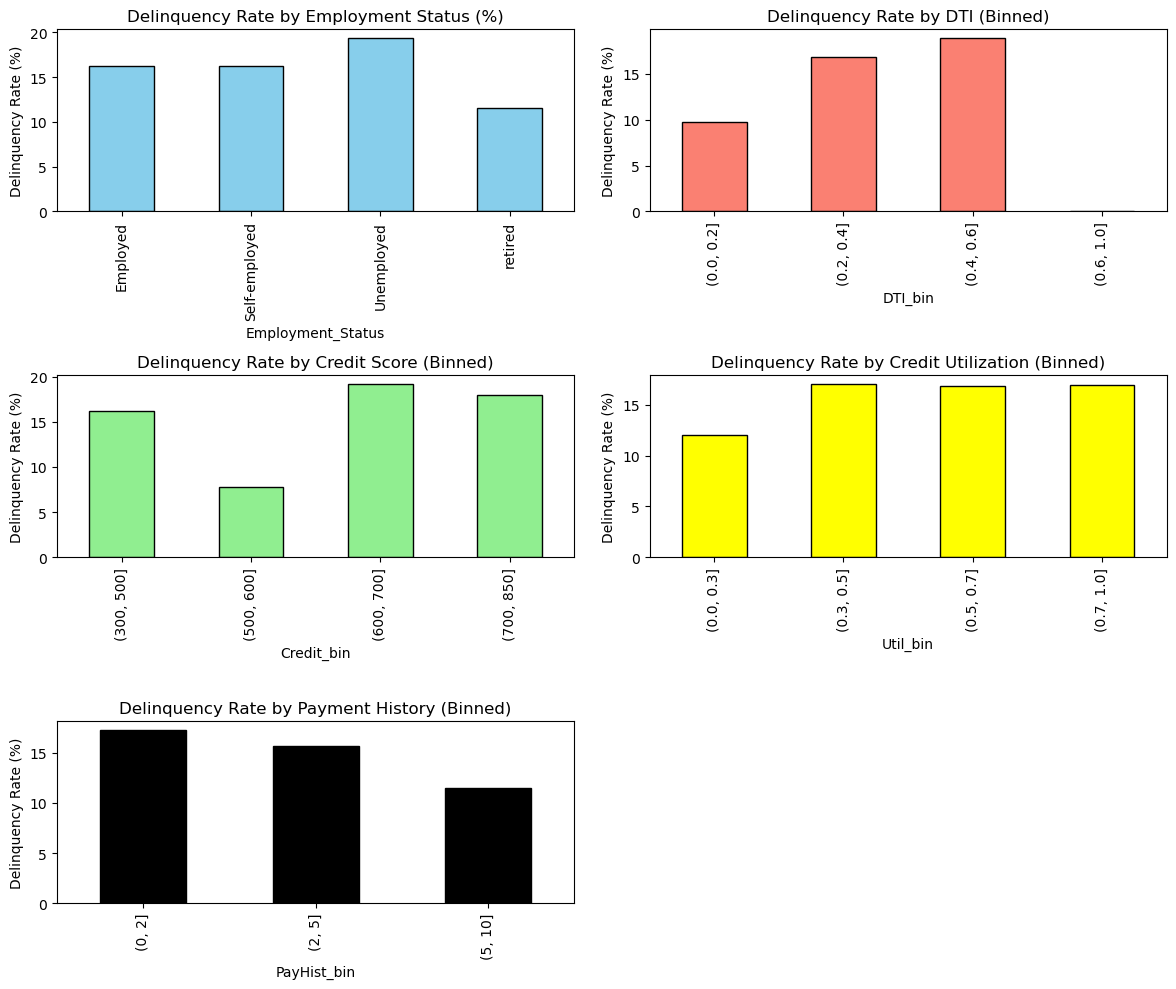

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(12,10))

# Employment Status
delinq_by_emp.plot(kind="bar", ax=axes[0,0], color="skyblue", edgecolor="black")
axes[0,0].set_title("Delinquency Rate by Employment Status (%)")
axes[0,0].set_ylabel("Delinquency Rate (%)")

# Debt-to-Income Ratio
delinq_by_dti.plot(kind="bar", ax=axes[0,1], color="salmon", edgecolor="black")
axes[0,1].set_title("Delinquency Rate by DTI (Binned)")
axes[0,1].set_ylabel("Delinquency Rate (%)")

# Credit Score
delinq_by_credit.plot(kind="bar", ax=axes[1,0], color="lightgreen", edgecolor="black")
axes[1,0].set_title("Delinquency Rate by Credit Score (Binned)")
axes[1,0].set_ylabel("Delinquency Rate (%)")

# Credit Utilization
delinq_by_util.plot(kind="bar", ax=axes[1,1], color="yellow", edgecolor="black")
axes[1,1].set_title("Delinquency Rate by Credit Utilization (Binned)")
axes[1,1].set_ylabel("Delinquency Rate (%)")

# Payment History
delinq_by_payhist.plot(kind="bar", ax=axes[2,0], color="black", edgecolor="black")
axes[2,0].set_title("Delinquency Rate by Payment History (Binned)")
axes[2,0].set_ylabel("Delinquency Rate (%)")

# Hide empty subplot (bottom-right)
axes[2,1].axis("off")

plt.tight_layout()
plt.show()


In [21]:
df.head(10)

Customer_ID  Age    Income  Credit_Score  Credit_Utilization  \
0    CUST0001   56  165580.0         398.0            0.390502   
1    CUST0002   69  100999.0         493.0            0.312444   
2    CUST0003   46  188416.0         500.0            0.359930   
3    CUST0004   32  101672.0         413.0            0.371400   
4    CUST0005   60   38524.0         487.0            0.234716   
5    CUST0006   25   84042.0         700.0            0.650540   
6    CUST0007   38   35056.0         354.0            0.390581   
7    CUST0008   56  123215.0         415.0            0.532715   
8    CUST0009   36   66991.0         405.0            0.413035   
9    CUST0010   40   34870.0         679.0            0.361824   

   Missed_Payments  Delinquent_Account  Loan_Balance  Debt_to_Income_Ratio  \
0                3                   0       16310.0              0.317396   
1                6                   1       17401.0              0.196093   
2                0                   0       13761.0              0.301655   
3                3                   0       88778.0              0.264794   
4                2                   0       13316.0              0.510583   
5                6                   0       48361.0              0.260688   
6                3                   0        4638.0              0.484265   
7                5                   0       55776.0              0.358695   
8                5                   1       45776.0              0.219854   
9                4                   0       93922.0              0.333081   

  Employment_Status  ...  Month_1  Month_2  Month_3  Month_4  Month_5  \
0          Employed  ...     Late     Late   Missed     Late   Missed   
1     Self-employed  ...   Missed   Missed     Late   Missed  On-time   
2     Self-employed  ...   Missed     Late     Late  On-time   Missed   
3        Unemployed  ...     Late   Missed     Late   Missed     Late   
4     Self-employed  ...   Missed  On-time   Missed     Late     Late   
5        Unemployed  ...  On-time     Late   Missed   Missed   Missed   
6          Employed  ...  On-time   Missed   Missed     Late   Missed   
7          Employed  ...  On-time  On-time  On-time     Late   Missed   
8          Employed  ...  On-time  On-time  On-time   Missed     Late   
9          Employed  ...  On-time   Missed   Missed  On-time   Missed   

   Month_6     DTI_bin  Credit_bin    Util_bin  PayHist_bin  
0     Late  (0.2, 0.4]  (300, 500]  (0.3, 0.5]   (2.0, 5.0]  
1  On-time  (0.0, 0.2]  (300, 500]  (0.3, 0.5]  (5.0, 10.0]  
2     Late  (0.2, 0.4]  (300, 500]  (0.3, 0.5]          NaN  
3     Late  (0.2, 0.4]  (300, 500]  (0.3, 0.5]   (2.0, 5.0]  
4     Late  (0.4, 0.6]  (300, 500]  (0.0, 0.3]   (0.0, 2.0]  
5     Late  (0.2, 0.4]  (600, 700]  (0.5, 0.7]  (5.0, 10.0]  
6     Late  (0.4, 0.6]  (300, 500]  (0.3, 0.5]   (2.0, 5.0]  
7     Late  (0.2, 0.4]  (300, 500]  (0.5, 0.7]   (2.0, 5.0]  
8  On-time  (0.2, 0.4]  (300, 500]  (0.3, 0.5]   (2.0, 5.0]  
9   Missed  (0.2, 0.4]  (600, 700]  (0.3, 0.5]   (2.0, 5.0]  

[10 rows x 23 columns]

In [22]:
# Drop leakage columns
customer_ids = df["Customer_ID"].copy()

leakage_cols = [
    "Customer_ID", "Month_4", "Month_5", "Month_6",
    "prediction_label", "prediction_score",
    "DTI_bin", "Credit_bin", "Util_bin", "PayHist_bin"
]

df = df.drop(columns=leakage_cols, errors="ignore")

In [23]:
!pip install pycaret

Modeling using Gen AI ( pyncret )

In [24]:
# Import classification module
from pycaret.classification import *

In [25]:
from pycaret.classification import setup, compare_models, evaluate_model, predict_model

# Setup classification experiment
exp = setup(
    data = df,
    target = "Delinquent_Account",   # target variable
    session_id = 123,                # reproducibility
    train_size = 0.8,                # 80/20 split
    normalize = True,                # scale numeric features
    categorical_imputation = 'mode', # fill missing categorical values
    numeric_imputation = 'mean',     # fill missing numeric values
    verbose = False                  # suppress setup logs if you want a clean output
)


In [26]:
# Compare models (AutoML)
best_model = compare_models(sort = 'AUC')  # sorts models by ROC AUC

In [27]:
#  Evaluate model using  ROC, PR curve, confusion matrix
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Interpreting model with SHAP.
SHAP (SHapley Additive exPlanations) is a method to explain the predictions of a machine learning model by showing how much each feature contributes


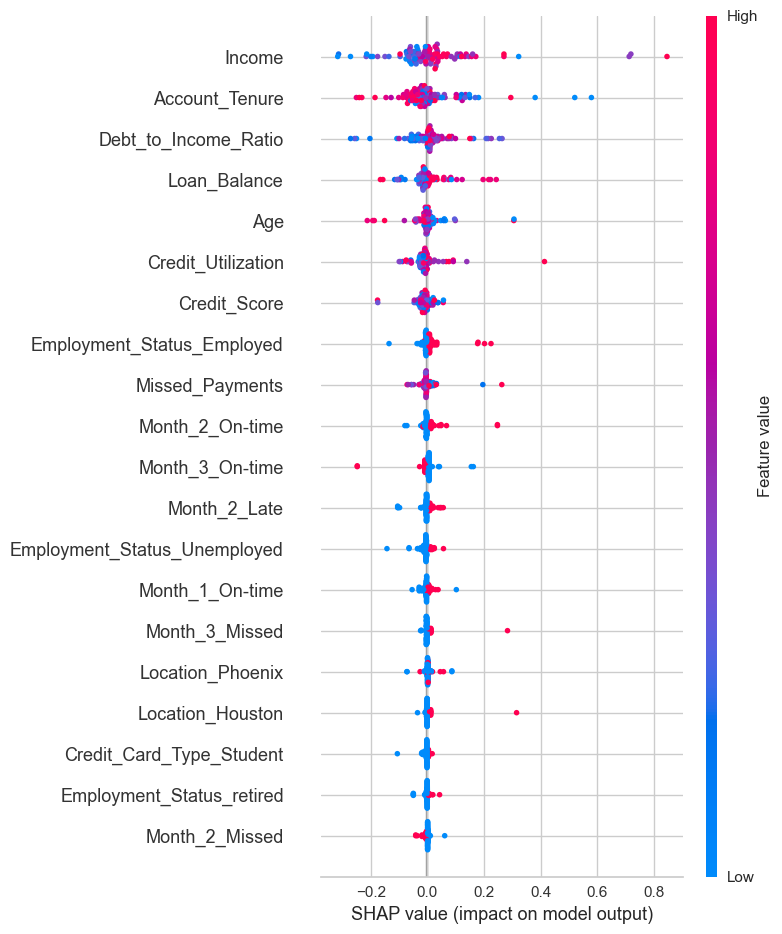

In [28]:

# Only include tree-based models
best_model = compare_models(include=["lightgbm", "rf", "et", "dt"], sort="AUC")

# Now interpret works
interpret_model(best_model, plot="summary")

SHAP summary plot shows the overall impact of features on a machine learning model's output (which features are most influential and how they affect the predictions with the most impactful feature at the top)

High Impact Features (at the top) → Customer_ID, Month_6_Late. Wide spreads mean they can shift predictions strongly in either direction.

Customer_ID → unusually important; this suggests data leakage since IDs shouldn’t affect outcomes. Needs investigation.

Month_6_Late → late in month 6 (red) raises default risk; not late (blue) lowers it.

Month_1_On-time → being on time lowers default risk; not on time raises it.

Location_Los Angeles → being in LA reduces risk; not in LA increases it.

Extra Trees, Decision Tree, Random Forest are showing high accuracy (0.84) but zero recall, precision, and F1 which signifies
Severe class imbalance

Most customers in the dataset are not delinquent and models are just predicting “Not Delinquent” for everyone, which gives high accuracy but fails to detect delinquents (hence recall = 0).

AUC is near random (~0.5)Confirms the model isn’t separating delinquent(Customers who are paying their credit obligations on time) vs. non-delinquent customers (Customers who have missed payments).

ACTION: Use Smote to solve the imbalance

In [29]:
#enable  balancing 

from imblearn.over_sampling import SMOTE

exp = setup(
    data=df,
    target="Delinquent_Account",
    session_id=123,
    train_size=0.8,
    normalize=True,
    categorical_imputation="mode",
    numeric_imputation="mean",
    fix_imbalance=True,
    fix_imbalance_method=SMOTE()   
)


Summary

Original data shape → (500, 23)
Transformed data shape → (772, 56), SMOTE created synthetic samples of the minority class (delinquent customers/training data) to balance the dataset.

Train set (672, 56) / Test set (100, 56).Data was split into 80% train / 20% test after balancing.


In [30]:
#  Compare models after smote
best_model = compare_models(sort="Recall")

In [31]:
# Evaluate the best model
evaluate_model(best_model)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

this plot provides a visual summary of all the data preprocessing and modeling steps that PyCaret performed behind the scenes to create the final model

Raw data: This is your initial, unprocessed dataset.

SimpleImputer(one for numerical, one for categorical): ensures data is clean before it's used for training.

OneHotEncoder: converts categorical data into a numerical format createing new binary columns that the machine learning model can understand.

TargetEncoder: replaces each category with a numerical value based on the mean of the target variable for that category.

FixImbalance: addresses the class imbalance in the target variable (Delinquent_Account)

StandardScaler:  scales  numerical features so they have a mean of 0 and a standard deviation of 1. 

KNeighborsClassifier:  where the model is trained on the preprocessed data. 

 Hyperparameter Tuning

calibration ( PyCaret, calibrate_model()) : improve the probability estimates of a trained classifier by applying probability calibration.Helps improve KNN model predictive performance , especially the k value.


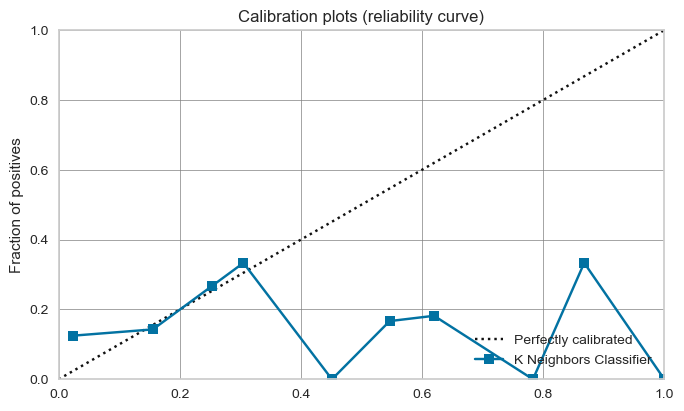

In [32]:
# Create KNN model
knn = create_model('knn')

# Calibrate the KNN model
calibrated_knn = calibrate_model(knn, method='isotonic') 

# Plot calibration curve
plot_model(calibrated_knn, plot='calibration')



In [33]:
#  Finalize model (train on full dataset)
final_model = finalize_model(best_model)

In [34]:
#  Save model for deployment
save_model(final_model, "customer_delinquency_model")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Age', 'Income', 'Credit_Score',
                                              'Credit_Utilization',
                                              'Missed_Payments', 'Loan_Balance',
                                              'Debt_to_Income_Ratio',
                                              'Account_Tenure'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               s...
                            

In [35]:
#  Predict on new/unseen data
predictions = predict_model(final_model, data=df)

In [36]:
# Show sample predictions
predictions.head()

Age    Income  Credit_Score  Credit_Utilization  Missed_Payments  \
0   56  165580.0         398.0            0.390502                3   
1   69  100999.0         493.0            0.312444                6   
2   46  188416.0         500.0            0.359930                0   
3   32  101672.0         413.0            0.371400                3   
4   60   38524.0         487.0            0.234716                2   

   Loan_Balance  Debt_to_Income_Ratio Employment_Status  Account_Tenure  \
0       16310.0              0.317396          Employed              18   
1       17401.0              0.196093     Self-employed               0   
2       13761.0              0.301655     Self-employed               1   
3       88778.0              0.264794        Unemployed              15   
4       13316.0              0.510583     Self-employed              11   

  Credit_Card_Type     Location Month_1  Month_2 Month_3  Delinquent_Account  \
0          Student  Los Angeles    Late     Late  Missed                   0   
1         Standard      Phoenix  Missed   Missed    Late                   1   
2         Platinum      Chicago  Missed     Late    Late                   0   
3         Platinum      Phoenix    Late   Missed    Late                   0   
4         Standard      Phoenix  Missed  On-time  Missed                   0   

   prediction_label  prediction_score  
0                 0               0.8  
1                 1               0.8  
2                 1               0.6  
3                 0               1.0  
4                 1               0.6

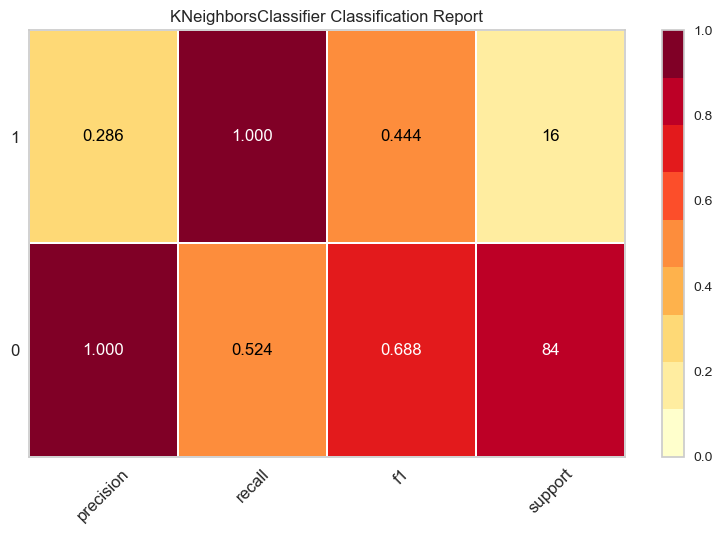

In [37]:
# Classification Report
plot_model(final_model, plot="class_report")

This KNN model prioritizes catching all delinquent customers (Recall = 100%), which is great for risk minimization.

But it sacrifices precision, meaning many safe customers get falsely flagged as delinquent.

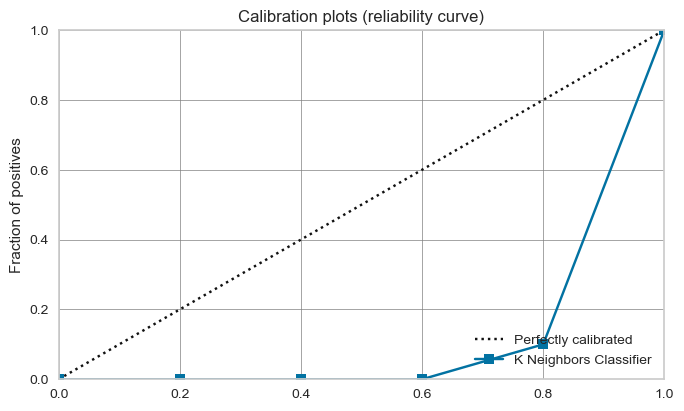

In [38]:
#Probability Distribution
plot_model(final_model, plot="calibration")

In [39]:
# Add Customer_ID back for reporting
predictions["Customer_ID"] = customer_ids.values

#  Create risk ranking with ID included
risk_ranking = predictions.sort_values("prediction_score", ascending=False)
risk_ranking[["Customer_ID", "prediction_label", "prediction_score"]].head(10)


Customer_ID  prediction_label  prediction_score
423    CUST0424                 1               1.0
163    CUST0164                 1               1.0
79     CUST0080                 0               1.0
386    CUST0387                 0               1.0
274    CUST0275                 0               1.0
76     CUST0077                 0               1.0
389    CUST0390                 1               1.0
272    CUST0273                 1               1.0
394    CUST0395                 0               1.0
298    CUST0299                 1               1.0